## Load libraries

In [93]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import tensorflow as tf

from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Transform

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from google.protobuf.json_format import MessageToDict
import pprint

## Load Data

In [2]:
## download the dataset
# Directory of the raw data files
_data_root = './data/covertype'
# Path to the raw training data
_data_filepath = os.path.join(_data_root, 'covertype_train.csv')
# Download data
os.makedirs(_data_root, exist_ok=True)
if not os.path.isfile(_data_filepath):
 #https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/
 url = 'https://docs.google.com/uc?export= \
 download&confirm={{VALUE}}&id=1lVF1BCWLH4eXXV_YOJzjR7xZjj-wAGj9'
 r = requests.get(url, allow_redirects=True, stream=True)
 open(_data_filepath, 'wb').write(r.content)

# Read the CSV file into a DataFrame
if os.path.exists(_data_filepath):
    df = pd.read_csv(_data_filepath)
    print("Dataframe was loaded")  # Display the first few rows
else:
    print(f"File not found: {_data_filepath}")

Dataframe was loaded


## Feature Selection

### Data Exploration

In [3]:
# Se identifica el tipo de dato de cada una de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116203 entries, 0 to 116202
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           116203 non-null  int64 
 1   Aspect                              116203 non-null  int64 
 2   Slope                               116203 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    116203 non-null  int64 
 4   Vertical_Distance_To_Hydrology      116203 non-null  int64 
 5   Horizontal_Distance_To_Roadways     116203 non-null  int64 
 6   Hillshade_9am                       116203 non-null  int64 
 7   Hillshade_Noon                      116203 non-null  int64 
 8   Hillshade_3pm                       116203 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  116203 non-null  int64 
 10  Wilderness_Area                     116203 non-null  object
 11  Soil_Type                           116

In [4]:
# Se generan dos listas segun las caracteristicas de las variables para facilitar la exploracion
quantitative_variables = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

categorical_variables = ['Wilderness_Area', 'Soil_Type',
       'Cover_Type']

### Feature Analysis

#### Quantitative Variables

In [5]:
# Se exploran las variables cuantitativas mediantes metricas de estadistica basica
df[quantitative_variables].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2958.442553,155.611869,14.126572,268.815297,46.540890,2344.471993,212.080110,223.328537,142.583117,1974.181002
std,280.264645,111.826494,7.517868,212.401029,58.650981,1559.288208,26.956645,19.796919,38.365816,1316.012073
min,1860.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2808.000000,59.000000,9.000000,108.000000,7.000000,1101.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1986.000000,218.000000,226.000000,143.000000,1705.000000
75%,3163.000000,261.000000,18.000000,384.000000,69.000000,3311.000000,231.000000,237.000000,168.000000,2543.000000
max,3858.000000,360.000000,66.000000,1397.000000,598.000000,7116.000000,254.000000,254.000000,253.000000,7168.000000


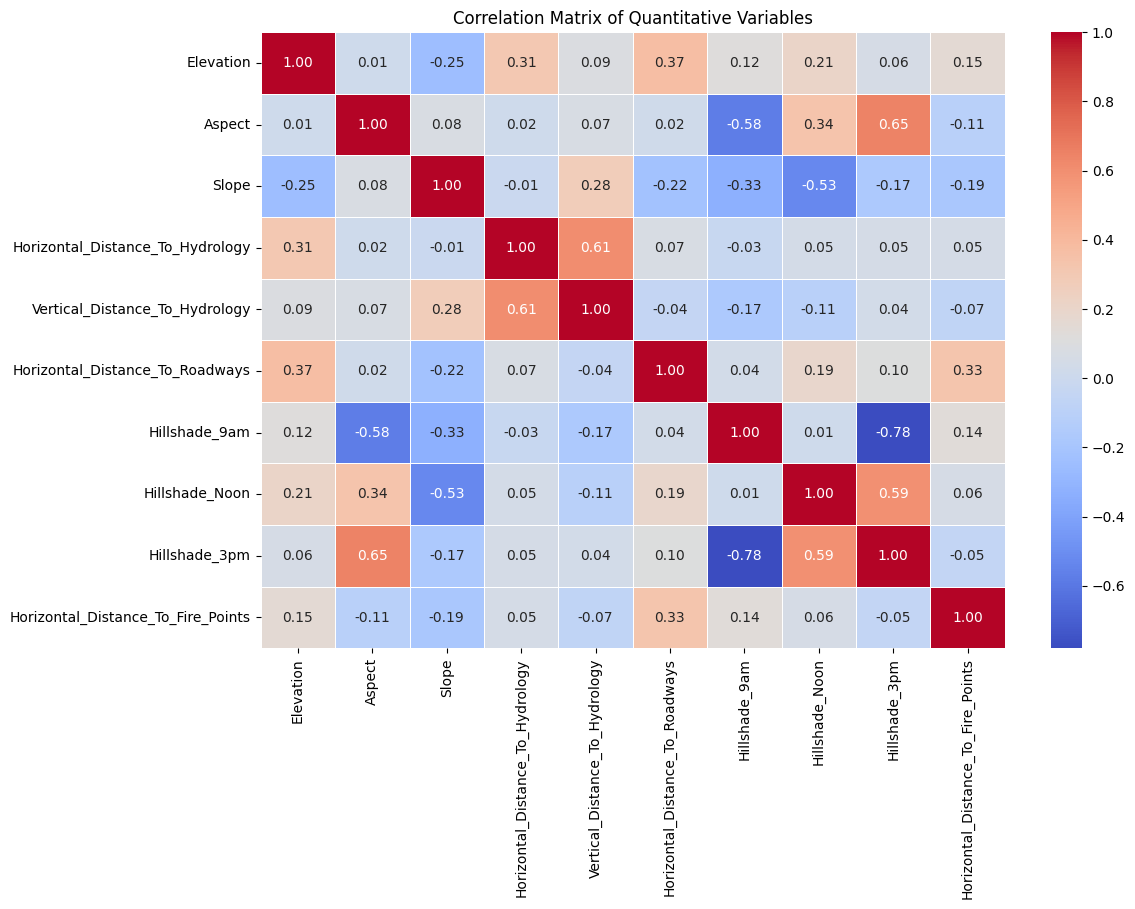

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Elevation,1.000000,0.013638,-0.246626,0.306427,0.089746,0.368821,0.118341,0.209270,0.056217,0.153658
Aspect,0.013638,1.000000,0.080560,0.017550,0.070517,0.024409,-0.576595,0.335843,0.646172,-0.111924
Slope,-0.246626,0.080560,1.000000,-0.011202,0.276691,-0.218410,-0.333211,-0.527148,-0.170408,-0.185317
Horizontal_Distance_To_Hydrology,0.306427,0.017550,-0.011202,1.000000,0.610122,0.074821,-0.026795,0.046380,0.052295,0.051770
Vertical_Distance_To_Hydrology,0.089746,0.070517,0.276691,0.610122,1.000000,-0.044835,-0.170377,-0.111661,0.038072,-0.070214
Horizontal_Distance_To_Roadways,0.368821,0.024409,-0.218410,0.074821,-0.044835,1.000000,0.037724,0.190562,0.104052,0.331464
Hillshade_9am,0.118341,-0.576595,-0.333211,-0.026795,-0.170377,0.037724,1.000000,0.013680,-0.780337,0.135143
Hillshade_Noon,0.209270,0.335843,-0.527148,0.046380,-0.111661,0.190562,0.013680,1.000000,0.590911,0.056642
Hillshade_3pm,0.056217,0.646172,-0.170408,0.052295,0.038072,0.104052,-0.780337,0.590911,1.000000,-0.050605
Horizontal_Distance_To_Fire_Points,0.153658,-0.111924,-0.185317,0.051770,-0.070214,0.331464,0.135143,0.056642,-0.050605,1.000000


In [94]:
# Se genera la matrix de correlaciones

corr_matrix = df[quantitative_variables].corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Quantitative Variables")
plt.show()

"""
Analisis:
No se identifican correlaciones directas o inversas mayores a 0.8, por consiguiente, no se descartan variables cuantitativas por correlacion
altamente significativa
"""
corr_matrix

In [65]:
# Distincion entre variables regresoras y objetivo

quantitative_variables = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

y = ['Cover_Type']

In [78]:
# Se procede a normalizar variables con el metodo Min_Max_Scaler

scaler = MinMaxScaler()
X_encoded_num = scaler.fit_transform(df[quantitative_variables])

df_X_encoded_num = pd.DataFrame(X_encoded_num, 
                          columns=scaler.get_feature_names_out(quantitative_variables))


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


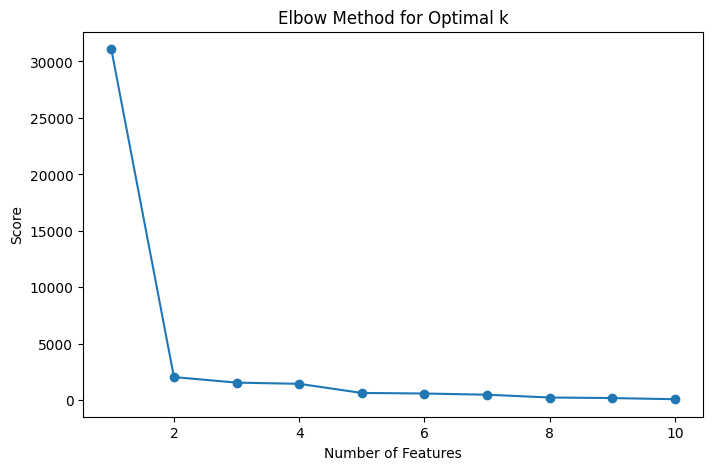

         Scores
0  31087.079657
1   2050.314700
2   1559.369722
3   1452.737911
4    643.862634
5    595.275348
6    488.221292
7    241.029561
8    190.497164
9     88.987497


In [74]:
# Para identificar el K optimo, se utiliza el metodo del codo.
# Para ello, se Calculan los puntajes para las variables numericas mediante el metodo ANOVA.
selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X_encoded_num, df[y])
scores = selector.scores_

# Se ordenan los puntajes obtenidos
sorted_scores = np.sort(scores)[::-1]

# Visualizacion de los scores (Metdo del codo)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_scores) + 1), sorted_scores, marker="o")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Elbow Method for Optimal k")
plt.show()

print(pd.DataFrame(sorted_scores, columns = ["Scores"]).head(10))

"""
Analisis: El punto de inflexion de la grafica de puntajes se identifica en 1 variable, no obstante, se
determina tomar como punto k optimo 4 variables, para no descartar la mayoria de las variables numericas y
contar con mas caracteristicas que enriquezcan al modelo.

Es importante resaltar que hay un trade off entre eliminar variables, dado que se reduce informacion que
reduce el costo computacional y elimina posible ruido, no obstante, tambien se puede incurrir en overfitting
porque la informacion podria no generalizar tan bien con nuevos datos

"""

In [90]:
# Se procede a realizar en analisis ANOVA con K optimo equivalente a 4. Se obtiene las variables
# numericas relevantes

k_num = 4
selector_num = SelectKBest(score_func=f_classif, k=k_num)
selector_num.fit(X_encoded_num, df[y] )
num_columns = df_X_encoded_num.columns
selected_num_features = list(num_columns[selector_num.get_support()])

print(selected_num_features)

['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
# Se genera el formato planteado en los requerimientos del proyecto

num_analysis_result = pd.DataFrame(zip(num_columns,selector_num.get_support()),columns=["Columns","Retain"])
print(num_analysis_result)

                              Columns  Retain
0                           Elevation    True
1                              Aspect   False
2                               Slope    True
3    Horizontal_Distance_To_Hydrology   False
4      Vertical_Distance_To_Hydrology   False
5     Horizontal_Distance_To_Roadways    True
6                       Hillshade_9am   False
7                      Hillshade_Noon   False
8                       Hillshade_3pm   False
9  Horizontal_Distance_To_Fire_Points    True


#### Categorical Variables

In [7]:
# Se realiza exploracion a las variables categoricas

for i in categorical_variables:
    print(f"variable: {i}")
    print(df[i].value_counts())
    print("--------------------")
"""
Analisis: 
Las variables categoricas estan altamente desbalaceadas, en especial "Wilderness_Area" y "Cover_Type" se concentran principalmente en 2 variables.
Por su parte, "Soil_Type" se concentra principalmente en 4 variables, por la cantidad de categorias, hay algunas con pocos valores.
"""
    

variable: Wilderness_Area
Rawah        52006
Commanche    50759
Cache         7525
Neota         5913
Name: Wilderness_Area, dtype: int64
--------------------
variable: Soil_Type
C7745    22912
C7202    11560
C7756    10539
C7757     9178
C7201     6690
C4703     6541
C7746     6068
C4744     5961
C7755     5130
C7700     4244
C4758     3443
C8771     3113
C8772     2720
C2705     2488
C4704     2396
C7102     1881
C8776     1729
C2703     1478
C2717     1378
C2704      977
C7101      787
C6102      690
C2702      592
C6101      565
C7702      539
C8703      385
C6731      375
C7790      324
C2706      322
C4201      257
C7709      242
C7710      194
C7103      156
C5101      123
C7701      101
C8708       63
C3502       24
C3501       19
C8707       18
C5151        1
Name: Soil_Type, dtype: int64
--------------------
variable: Cover_Type
1    56720
0    42307
2     7228
6     4045
5     3478
4     1892
3      533
Name: Cover_Type, dtype: int64
--------------------


'\nLas variables categoricas estan altamente desbalaceadas, en especial "Wilderness_Area" y "Cover_Type" se concentran principalmente en 2 variables.\nPor su parte, "Soil_Type" se concentra principalmente en 4 variables, por la cantidad de categorias, hay algunas con pocos valores.\n'

In [14]:
# Distincion entre variables regresoras y objetivo
X_categorical = ['Wilderness_Area', 'Soil_Type']
y = ['Cover_Type']

In [33]:

# Se realiza la transformacion de las variables categoricas (Variables dummy o one hot encoding)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
X_encoded_cat = encoder.fit_transform(df[X_categorical])
df_X_encoded_cat = pd.DataFrame(X_encoded_cat, 
                          columns=encoder.get_feature_names_out(X_categorical))
"""
Analisis: 
Se ha tomado la decision de codificar las variables categoricas a traves del metodo one-hot encoding o
variables dummy para evitar que las variables con poca importancia sobresalgan por el hecho de tener
una categoria mayor comparada a otras. Por ejemplo, si se codifican, puede ser mas relevante
la categoria 5 sobre la 3, por el simple hecho de procesamiento numerico y no por relevancia estadistica.
"""


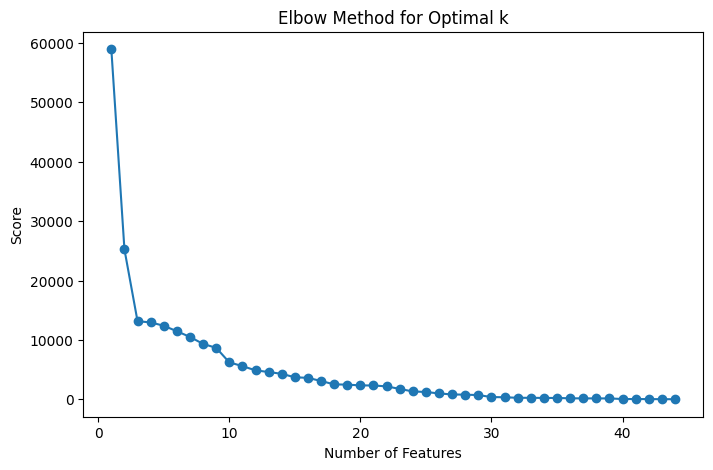

          Scores
0   58950.147862
1   25231.362551
2   13140.041410
3   12953.972802
4   12379.955945
5   11460.731728
6   10499.220266
7    9326.006995
8    8663.159076
9    6215.818530
10   5591.411835
11   4870.902424
12   4596.310224
13   4283.041070
14   3708.873316


In [75]:
# Se realiza el metodo del codo para determinar la cantidad optima de k para variables
# numericas
# Se Calculan los puntajes para las variables
selector = SelectKBest(score_func=chi2, k="all")  # Select all features
selector.fit(X_encoded_cat, df[y])
scores = selector.scores_

# Se ordenan los puntajes
sorted_scores = np.sort(scores)[::-1]

# Visualizacion de los scores (Metdo del codo)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_scores) + 1), sorted_scores, marker="o")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Elbow Method for Optimal k")
plt.show()

print(pd.DataFrame(sorted_scores, columns = ["Scores"]).head(15))


In [76]:
# Se realiza el analisis de chi2 para variables categoricas, con el objetivo de
# identificar las variables relevantes.

k_cat = 9
selector_cat = SelectKBest(score_func=chi2, k=k_cat)
selector_cat.fit(X_encoded_cat, df[y] )
cat_columns = df_X_encoded_cat.columns
selected_cat_features = list(cat_columns[selector_cat.get_support()])

print(selected_cat_features)

['Wilderness_Area_Cache', 'Soil_Type_C2703', 'Soil_Type_C2704', 'Soil_Type_C2705', 'Soil_Type_C2717', 'Soil_Type_C4703', 'Soil_Type_C8771', 'Soil_Type_C8772', 'Soil_Type_C8776']


In [89]:
# Se genera el formato planteado en los requerimientos del proyecto
cat_analysis_result = pd.DataFrame(zip(cat_columns,selector_cat.get_support()),columns=["Columns","Retain"])
print(cat_analysis_result)

                      Columns  Retain
0       Wilderness_Area_Cache    True
1   Wilderness_Area_Commanche   False
2       Wilderness_Area_Neota   False
3       Wilderness_Area_Rawah   False
4             Soil_Type_C2702   False
5             Soil_Type_C2703    True
6             Soil_Type_C2704    True
7             Soil_Type_C2705    True
8             Soil_Type_C2706   False
9             Soil_Type_C2717    True
10            Soil_Type_C3501   False
11            Soil_Type_C3502   False
12            Soil_Type_C4201   False
13            Soil_Type_C4703    True
14            Soil_Type_C4704   False
15            Soil_Type_C4744   False
16            Soil_Type_C4758   False
17            Soil_Type_C5101   False
18            Soil_Type_C5151   False
19            Soil_Type_C6101   False
20            Soil_Type_C6102   False
21            Soil_Type_C6731   False
22            Soil_Type_C7101   False
23            Soil_Type_C7102   False
24            Soil_Type_C7103   False
25          

## Feature Selection Function

In [4]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

quantitative_variables = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

categorical_variables = ['Wilderness_Area', 'Soil_Type']

target_value = ['Cover_Type']

In [7]:
def get_data():

    ## download the dataset
    # Directory of the raw data files
    _data_root = './data/covertype'
    # Path to the raw training data
    _data_filepath = os.path.join(_data_root, 'covertype_train.csv')
    # Download data
    os.makedirs(_data_root, exist_ok=True)
    if not os.path.isfile(_data_filepath):
     #https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/
     url = 'https://docs.google.com/uc?export= \
     download&confirm={{VALUE}}&id=1lVF1BCWLH4eXXV_YOJzjR7xZjj-wAGj9'
     r = requests.get(url, allow_redirects=True, stream=True)
     open(_data_filepath, 'wb').write(r.content)
    
    # Read the CSV file into a DataFrame
    if os.path.exists(_data_filepath):
        df = pd.read_csv(_data_filepath)
        print("Dataframe was loaded")  # Display the first few rows
    else:
        df = pd.read_csv()
        print(f"File not found: {_data_filepath}")

    return df

def numerical_feature_selection(df,num_variables,target_value,k_num=4):
    """
    Function:
    * Se realiza Feature Selection para variables numericas mediante analisis de ANOVA
    
    Inputs
    * df: dataframe objeto de analisis
    * num_variables: nombre de variables numericas
    * target_value: nombre de variable objetivo en el modelo de aprendizaje de maquina
    * k_num: cantidad de variables a seleccionar

    Outputs:
    * selected_num_features: variables numericas seleccionadas

    """   
    scaler = MinMaxScaler()
    X_encoded_num = scaler.fit_transform(df[num_variables])
    df_X_encoded_num = pd.DataFrame(X_encoded_num, 
                              columns=scaler.get_feature_names_out(num_variables))
    
    selector_num = SelectKBest(score_func=f_classif, k=k_num)
    selector_num.fit(X_encoded_num, df[target_value] )
    num_columns = df_X_encoded_num.columns
    selected_num_features = list(num_columns[selector_num.get_support()])
    
    num_analysis_result = pd.DataFrame(zip(num_columns,selector_num.get_support()),columns=["Columns","Retain"])
    print("---------------------------" )
    print("Selected Numerical Values" )
    print(num_analysis_result)
    
    return df_X_encoded_num[selected_num_features]

def categorical_feature_selection(df,cat_variables,target_value,k_cat=9):
    """
    Function:
    * Se realiza Feature Selection para variables numericas mediante analisis de Chi2
    
    Inputs
    * df: dataframe objeto de analisis
    * num_variables: nombre de variables categoricas
    * target_value: nombre de variable objetivo en el modelo de aprendizaje de maquina
    * k_num: cantidad de variables a seleccionar

    Outputs:
    * selected_num_features: variables categoricas seleccionadas

    """   
    encoder = OneHotEncoder(sparse_output=False)
    X_encoded_cat = encoder.fit_transform(df[cat_variables])
    df_X_encoded_cat = pd.DataFrame(X_encoded_cat, 
                          columns=encoder.get_feature_names_out(cat_variables))

    selector_cat = SelectKBest(score_func=chi2, k=k_cat)
    selector_cat.fit(X_encoded_cat, df[target_value] )
    cat_columns = df_X_encoded_cat.columns
    selected_cat_features = list(cat_columns[selector_cat.get_support()])
    
    cat_analysis_result = pd.DataFrame(zip(cat_columns,selector_cat.get_support()),columns=["Columns","Retain"])
    print("---------------------------" )
    print("Selected Categorical Values" )
    print(cat_analysis_result)
    
    return df_X_encoded_cat[selected_cat_features]

In [25]:
df = get_data()
num_f = numerical_feature_selection(df,quantitative_variables,target_value)
cat_f = categorical_feature_selection(df,categorical_variables,target_value)
df_processed = pd.concat([num_f , cat_f],axis=0)

Dataframe was loaded
---------------------------
Selected Numerical Values
                              Columns  Retain
0                           Elevation    True
1                              Aspect   False
2                               Slope    True
3    Horizontal_Distance_To_Hydrology   False
4      Vertical_Distance_To_Hydrology   False
5     Horizontal_Distance_To_Roadways    True
6                       Hillshade_9am   False
7                      Hillshade_Noon   False
8                       Hillshade_3pm   False
9  Horizontal_Distance_To_Fire_Points    True
---------------------------
Selected Categorical Values
                      Columns  Retain
0       Wilderness_Area_Cache    True
1   Wilderness_Area_Commanche   False
2       Wilderness_Area_Neota   False
3       Wilderness_Area_Rawah   False
4             Soil_Type_C2702   False
5             Soil_Type_C2703    True
6             Soil_Type_C2704    True
7             Soil_Type_C2705    True
8             Soil_Ty

/app/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:

df_processed

,Elevation,Slope,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Cache,Soil_Type_C2703,Soil_Type_C2704,Soil_Type_C2705,Soil_Type_C2717,Soil_Type_C4703,Soil_Type_C8771,Soil_Type_C8772,Soil_Type_C8776
0,0.566066,0.106061,0.142636,0.219029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.508509,0.272727,0.350618,0.217215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.656156,0.030303,0.614671,0.146763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.614114,0.196970,0.670883,0.104911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.487988,0.151515,0.505340,0.457589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116198,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116199,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116200,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116201,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
